In [7]:
import re
import umap
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

sys.path.append('../src')
from config import *
from utils import *
from preprocessing import *

In [8]:
# Load the dataset
data = pd.read_csv(f'../{data_file}')
label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = data[label_names]

# Number of samples in train dataset
num_samples = len(data)
print(f"Number of samples in the train dataset: {num_samples}")

Number of samples in the train dataset: 159571


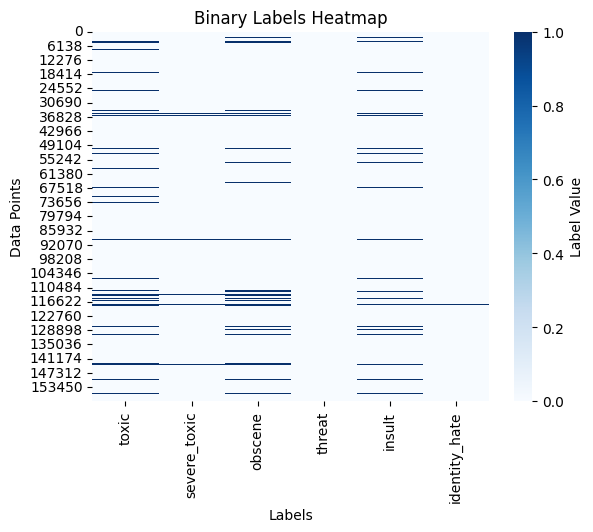

In [9]:
sns.heatmap(y, cmap='Blues', cbar_kws={'label': 'Label Value'})
plt.title('Binary Labels Heatmap')
plt.xlabel('Labels')
plt.ylabel('Data Points')
plt.show()

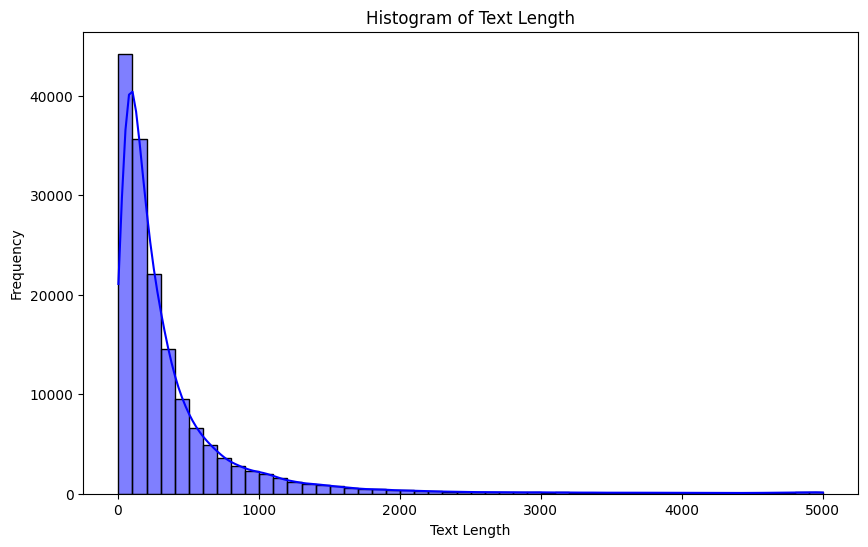

In [10]:
# Histogram of the length of samples
data['text_length'] = data['comment_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=50, kde=True, color='blue')
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
# Count emojies
def count_emojis(text):
    emoji_pattern = re.compile(r'[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\u2600-\u26FF\u2700-\u27BF\U0001F004]+')
    emojis = re.findall(emoji_pattern, text)
    return emojis

# Count the frequency of emojis in each comment
data['emoji_count'] = data['comment_text'].apply(lambda x: len(count_emojis(x)))

# Calculate the percentile of samples with emojis
total_samples = len(data)
samples_with_emojis = len(data[data['emoji_count'] > 0])
percentile_with_emojis = (samples_with_emojis / total_samples) * 100

print(f"Percentile of samples with emojis: {percentile_with_emojis:.2f}%")

Percentile of samples with emojis: 0.89%


In [12]:
# Sample stats: number of words, chars, symbols, capital letters, etc. in each sample
data['num_words'] = data['comment_text'].apply(lambda x: len(str(x).split()))
data['num_chars'] = data['comment_text'].apply(len)
data['num_symbols'] = data['comment_text'].apply(lambda x: sum(c.isalpha() or c.isspace() for c in x))
data['num_capital_letters'] = data['comment_text'].apply(lambda x: sum(c.isupper() for c in x))
data_stats = data[['num_words', 'num_chars', 'num_symbols', 'num_capital_letters']]
print("Sample Stats:")
print(data_stats.describe())

Sample Stats:
           num_words      num_chars    num_symbols  num_capital_letters
count  159571.000000  159571.000000  159571.000000        159571.000000
mean       67.273527     394.073221     374.663874            17.159628
std        99.230702     590.720282     563.785623            96.528103
min         1.000000       6.000000       0.000000             0.000000
25%        17.000000      96.000000      89.000000             3.000000
50%        36.000000     205.000000     194.000000             7.000000
75%        75.000000     435.000000     415.000000            15.000000
max      1411.000000    5000.000000    5000.000000          4960.000000


In [13]:
# Filter special symbols, clean sample's text
data['cleaned_text'] = data['comment_text'].apply(clean_text)

In [14]:
# Convert text to vectors using TfIdfVectorizer
X = data['cleaned_text']
X, vectorizer = fit_vectorize(X)

n_features = X.shape[1]
print(f"Length of tfidf vectors: {n_features}")

Length of tfidf vectors: 182231


In [16]:
# Imbalance
samples_per_label = y.sum(axis=0)

# Imbalance ratio for each label
imbalance_ratios_per_label = samples_per_label / len(y)
print("Samples Ratio for Each Label:")
print(imbalance_ratios_per_label)

# Overall imbalance ratio
overall_imbalance_ratio = imbalance_ratios_per_label.max() / imbalance_ratios_per_label.min()
print("\nOverall Imbalance Ratio:", overall_imbalance_ratio)

Samples Ratio for Each Label:
toxic            0.095844
severe_toxic     0.009996
obscene          0.052948
threat           0.002996
insult           0.049364
identity_hate    0.008805
dtype: float64

Overall Imbalance Ratio: 31.99581589958159


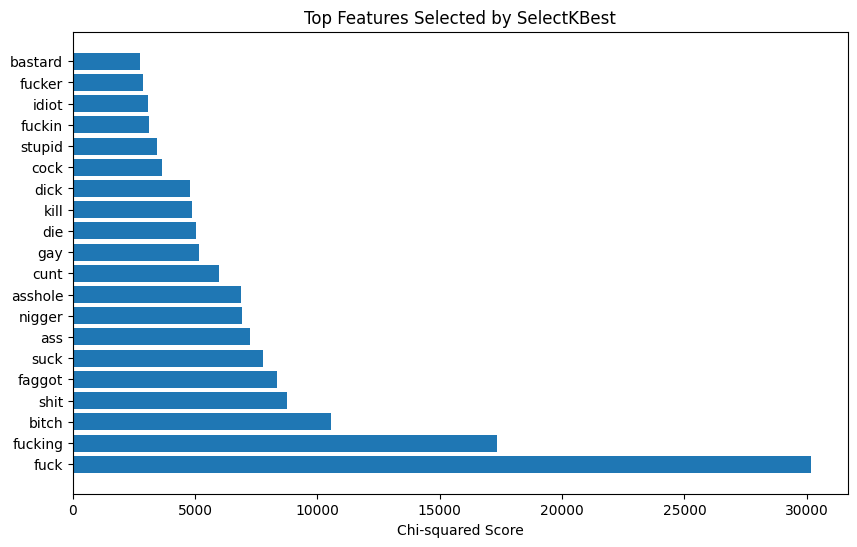

In [18]:
# Select relevant features
if use_feature_selection:
    X, selector, selected_feature_names, selected_feature_scores = fit_select_features(
        X,
        y,
        vectorizer.get_feature_names_out(),
        features_to_keep=features_to_keep
    )
    
    # Plot the top N features
    top_n = 20  # Change this to the desired number of top features to visualize
    plt.figure(figsize=(10, 6))
    plt.barh(selected_feature_names[:top_n], selected_feature_scores[:top_n])
    plt.xlabel('Chi-squared Score')
    plt.title('Top Features Selected by SelectKBest')
    plt.show()

In [ ]:
# Reduce dimentions
X_reduced = reduce_dimentions(X, f'../{pca_model}')

# Scale
X_tfidf = scale(X_reduced, f'../{scaler_model}')

# KMeans
X_tfidf = predict_kmeans(X_tfidf, f'../{kmeans_model}')

Explained Variance Ratios: [0.02633    0.01732256]


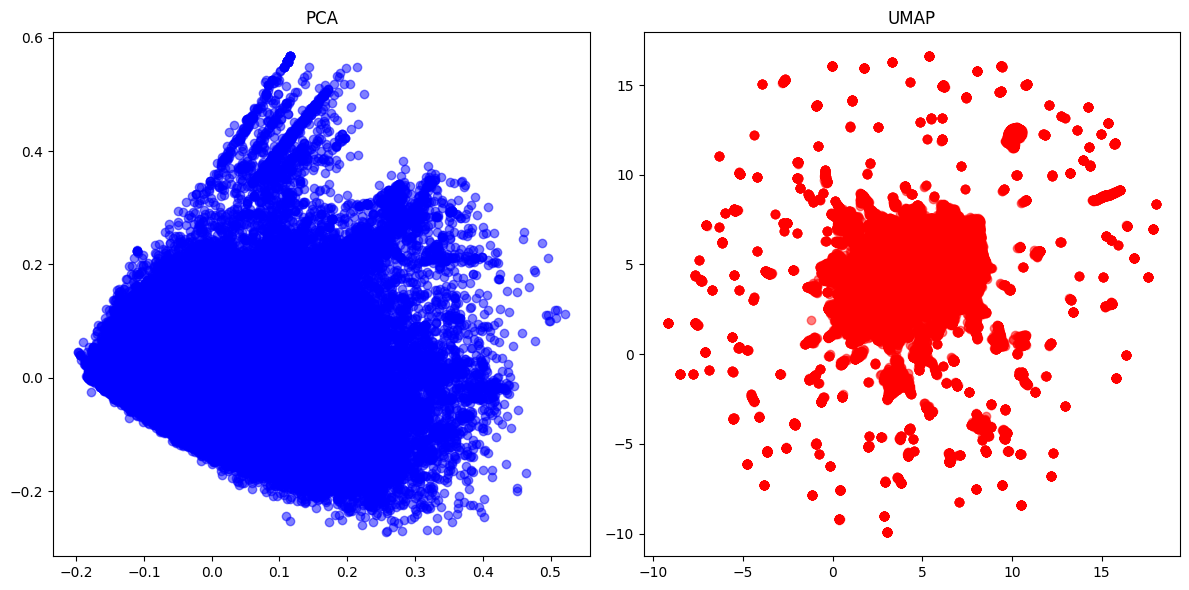

In [ ]:
# 2d PCA
n_components_pca = 2
pca = PCA(n_components=n_components_pca)

pca_result_2d = pca.fit_transform(X.toarray())
print("Explained Variance Ratios:", pca.explained_variance_ratio_)

# 2d UMAP
# Step 1: PCA to reduce dimensions
n_components_pca = 200
pca = PCA(n_components=n_components_pca)
tfidf_pca = pca.fit_transform(X.toarray())

# Step 2:UMAP
n_components_umap = 2
umap_model = umap.UMAP(n_components=n_components_umap)
tfidf_pca += np.random.normal(0, 1e-3, tfidf_pca.shape)
umap_result_2d = umap_model.fit_transform(tfidf_pca)

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(pca_result_2d[:, 0], pca_result_2d[:, 1], c='b', marker='o', alpha=0.5)
plt.title('PCA')

# Plot UMAP
plt.subplot(1, 2, 2)
plt.scatter(umap_result_2d[:, 0], umap_result_2d[:, 1], c='r', marker='o', alpha=0.5)
plt.title('UMAP')

plt.tight_layout()
plt.show()

d:\Projects\ml-lab-4\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Projects\ml-lab-4\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Projects\ml-lab-4\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Projects\ml-lab-4\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

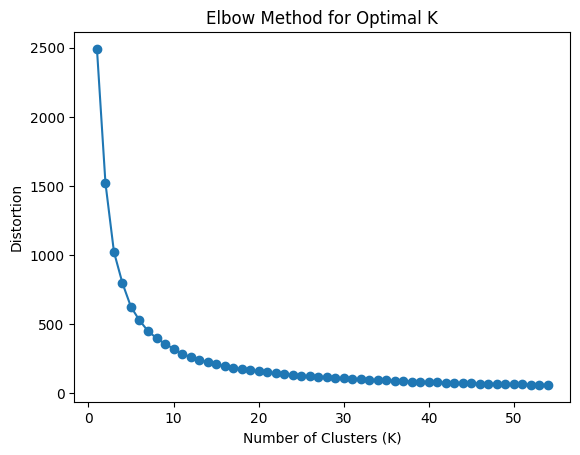

In [ ]:
# Elbow Method
plot_kmeans(X, )